In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import random 


In [2]:
df = pd.read_csv("../Figure7_PLS-DA/pheno_terpenoids.tsv",sep="\t",index_col=0)
df.head()

,wf,thrips,5.541_67.0557,7.060_95.0168,9.272_93.0728,9.472_91.0566,9.653_91.0565,10.148_93.0730,10.581_105.0363,10.873_119.0877,...,26.529_131.0872,26.595_91.0568,26.689_109.1032,26.803_111.0836,26.833_81.0727,27.083_97.0317,27.996_91.0565,28.382_97.0323,30.160_91.0569,32.503_159.8606
sample,,,,,,,,,,,,,,,,,,,,,
S lyc MM,non-toxic,non-toxic,0.00000,0.0,0.000,0.0000,88210.77165,0.00000,0.00000,32617.13711,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
S per LA1278,non-toxic,toxic,234383.78650,0.0,0.000,0.0000,131824.19000,0.00000,800290.02030,0.00000,...,0.0,0.0,0.0,9153.957334,0.0,0.0,0.0,0.0,0.0,0.0
S hua LA1364,non-toxic,non-toxic,0.00000,0.0,104528.752,45335.4665,27304.44693,90430.09761,0.00000,0.00000,...,0.0,0.0,0.0,5561.180230,0.0,0.0,0.0,0.0,0.0,0.0
S che LA1401,non-toxic,toxic,0.00000,0.0,0.000,0.0000,457891.15640,0.00000,32459.72293,0.00000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
S pim LA1578,non-toxic,toxic,12809.66965,0.0,0.000,0.0000,221391.28520,0.00000,0.00000,24737.81096,...,0.0,0.0,0.0,9495.496480,0.0,0.0,0.0,0.0,0.0,0.0


# Whitefly analysis

## get the X and y arrays

In [3]:
# get whitefly classes
y = df["wf"].tolist()
stratify_info = df['wf'].map({'non-toxic': 0, 'toxic': 1})

# get matrix X of volatile values
X = df.iloc[:,2:]
X.head()

,5.541_67.0557,7.060_95.0168,9.272_93.0728,9.472_91.0566,9.653_91.0565,10.148_93.0730,10.581_105.0363,10.873_119.0877,11.056_91.0567,11.572_91.0564,...,26.529_131.0872,26.595_91.0568,26.689_109.1032,26.803_111.0836,26.833_81.0727,27.083_97.0317,27.996_91.0565,28.382_97.0323,30.160_91.0569,32.503_159.8606
sample,,,,,,,,,,,,,,,,,,,,,
S lyc MM,0.00000,0.0,0.000,0.0000,88210.77165,0.00000,0.00000,32617.13711,0.00000,0.000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
S per LA1278,234383.78650,0.0,0.000,0.0000,131824.19000,0.00000,800290.02030,0.00000,55971.00761,0.000,...,0.0,0.0,0.0,9153.957334,0.0,0.0,0.0,0.0,0.0,0.0
S hua LA1364,0.00000,0.0,104528.752,45335.4665,27304.44693,90430.09761,0.00000,0.00000,0.00000,624085.817,...,0.0,0.0,0.0,5561.180230,0.0,0.0,0.0,0.0,0.0,0.0
S che LA1401,0.00000,0.0,0.000,0.0000,457891.15640,0.00000,32459.72293,0.00000,34284.95912,0.000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
S pim LA1578,12809.66965,0.0,0.000,0.0000,221391.28520,0.00000,0.00000,24737.81096,0.00000,0.000,...,0.0,0.0,0.0,9495.496480,0.0,0.0,0.0,0.0,0.0,0.0


## Define function to run the Random Forest 

In [4]:
# define main random forest routine.. uses 6 splits to partition data
from sklearn.metrics import classification_report

def single_run(X,y,rs,disp=False,nb_of_splits = 6,nb_of_trees=1000):
    """
    This function takes a feature matrix (X) and a label array (y) and fits 
    a number of random forest classifier based on the specified number of splits. 
    """

    number_of_splits = nb_of_splits
    
    # create dataframes to accomodate computed values for each variable importance + real/predicted y values
    variableImportance = pd.DataFrame(np.zeros([X.shape[1],number_of_splits]))    
    dfy = pd.DataFrame(y,columns=['tox'])
    yhat = pd.DataFrame(['']*len(y),columns=['predict_tox'],dtype=np.str)
    
    # Stratified K-fold cross validator: provides train/test indices to split data in train/test sets
    kfold = StratifiedKFold(n_splits=number_of_splits,random_state=rs)
    
    splitnr = 0
    
    # Splits the X and y arrays n times (as specified by number of splits)
    # Initialise a Random Forest classifier with the specified number of trees and using class weights. 
    # Random state is fixed so that results are reproducible from run to run.
    for train_index, test_index in kfold.split(X,y):
        nt = 1/sum(stratify_info[train_index]==0) # calculates a weight for the non-toxic class (corrects for class imbalance)
        tx = 1/sum(stratify_info[train_index]==1) # calculates a weight for the toxic class (corrects for class imbalance)   
        rf = RandomForestClassifier(n_estimators=nb_of_trees,
                                    class_weight={"toxic":tx,"non-toxic":nt},
                                    random_state=rs)

        rf = rf.fit(X.iloc[train_index,:],dfy.iloc[train_index].values.ravel())

        # predict class values
        y_pred = rf.predict(X.iloc[test_index,:])
        for j in range(len(y_pred)):    
            yhat.iloc[test_index[j]] = y_pred[j]    
                  
        variableImportance.iloc[:,splitnr] = rf.feature_importances_
        splitnr+=1
        
    if disp:
        print(classification_report(y, yhat))
        pdata = variableImportance.copy()
        pdata.rename(columns={i:'split{0}'.format(i) for i in range(6)},inplace=True)
        pdata['x'] = range(variableImportance.shape[0])
        pdata.head()
        sns.lineplot(data=pdata)
    
    return [variableImportance,yhat]

## Extract feature importance from the RF runs

In [5]:
feature_importance=pd.DataFrame(columns=['run{0}'.format(i+1) for i in range(5)])
feature_importance_sd=pd.DataFrame(columns=['run{0}'.format(i+1) for i in range(5)])

yhat = pd.DataFrame(columns=['run{0}'.format(i+1) for i in range(5)])

#run the normal procedure 5 times with different seeds
#concatenate the predicted y's and the feature importance for analysis later
for i in range(5):
    vi,yh = single_run(X,y,i,False)
    
    feature_importance.iloc[:,i] = vi.mean(axis=1)
    feature_importance_sd.iloc[:,i] = vi.std(axis=1)
    yhat.iloc[:,i]=yh.iloc[:,0]


In [6]:
# determine the average en std deviations 
mean_varimportance = feature_importance.mean(axis=1)
# sum the variances (=squared std) and then take the mean
pooled_std = np.sqrt((feature_importance_sd**2).mean(axis=1))

# create panda for convenience
yerr = pd.concat([mean_varimportance-2*pooled_std, mean_varimportance,mean_varimportance+2*pooled_std],axis=1)

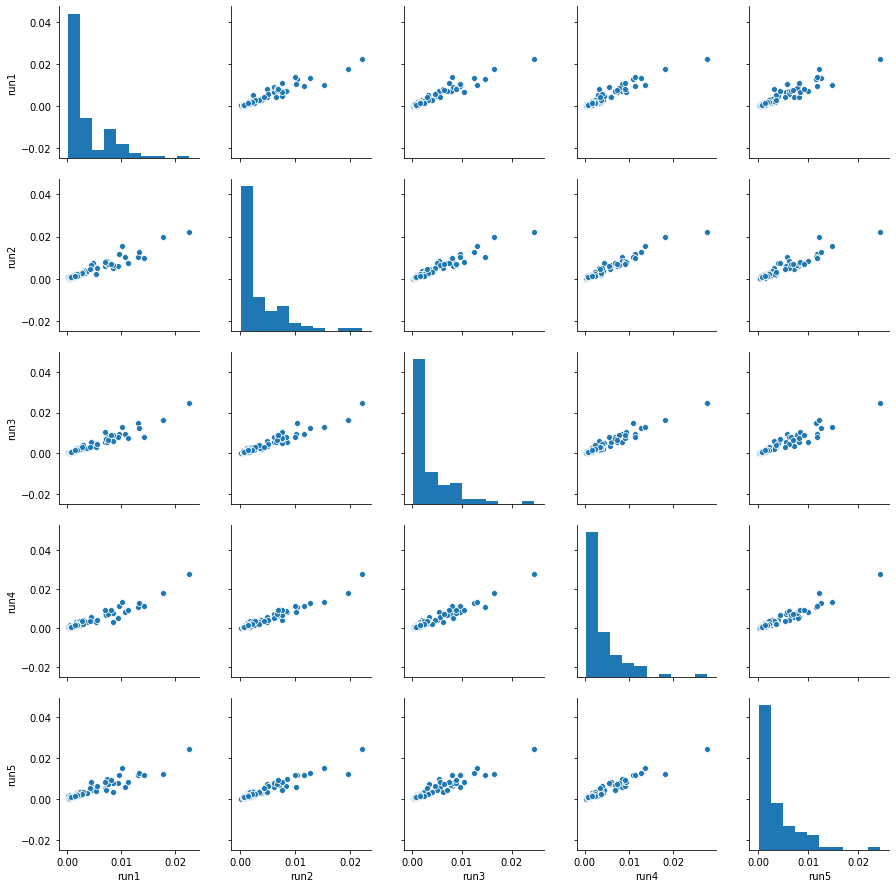

In [7]:
# plot the variable importances for each run and compare them to each other -> gives idea of stability 
sns.pairplot(data=feature_importance_sd)

# Permutations to extract p-values for each feature importance

In [8]:
nrperm = 100
yperms = pd.DataFrame(columns=['perm{0}'.format(i+1) for i in range(nrperm)])
secure_random = random.SystemRandom()

In [9]:
feature_importance_perm=pd.DataFrame(columns=['perm{0}'.format(i+1) for i in range(nrperm)])
yhat_perm=pd.DataFrame(columns=['perm{0}'.format(i+1) for i in range(nrperm)])

# create dataframe with y vector
dfy = pd.DataFrame(y,columns=['tox'])


for perm in range(nrperm):    
    # generate random numbers
    randomfloat = [secure_random.random() for r in range(len(y))]
    # create new ynew matrix
    ynew = dfy.iloc[np.argsort(randomfloat)]
    # reindex the vector
    ynew.index = range(len(y))
    # store this matrix for later
    yperms.iloc[:,perm]=ynew.iloc[:,0].copy()
    
    # set to fixed seed 1234 (arbitraryly)
    a,yh = single_run(X,ynew,1234,False)
    feature_importance_perm.iloc[:,perm] = a.mean(axis=1)
    yhat_perm.iloc[:,perm]=yh.iloc[:,0]
    

In [10]:
# routine to determine pvalue of average value (x) based on results scored by random generated data (X)
def iperc(x,X):
    
    df = pd.DataFrame(index=X.index,columns=['p-value'])
    
    for i in range(len(x)):            
        pn = sum(X.iloc[i,:]<x.iloc[i])/X.shape[0]
        pp = sum(X.iloc[i,:]>=x.iloc[i])/X.shape[0]
    
        df.iloc[i] = min(pn,pp)
            
    return df
    

In [11]:
# create some pandas just for plotting 
minp = feature_importance_perm.min(axis=1)
maxp = feature_importance_perm.max(axis=1)

yerr_plot = pd.concat([minp, mean_varimportance,maxp],axis=1)
yerr_plot.columns = ['min_perm','avg','max_perm']
yerr_plot['sig']=(minp>mean_varimportance) | (maxp<mean_varimportance)
yerr_plot['x'] = range(yerr.shape[0])

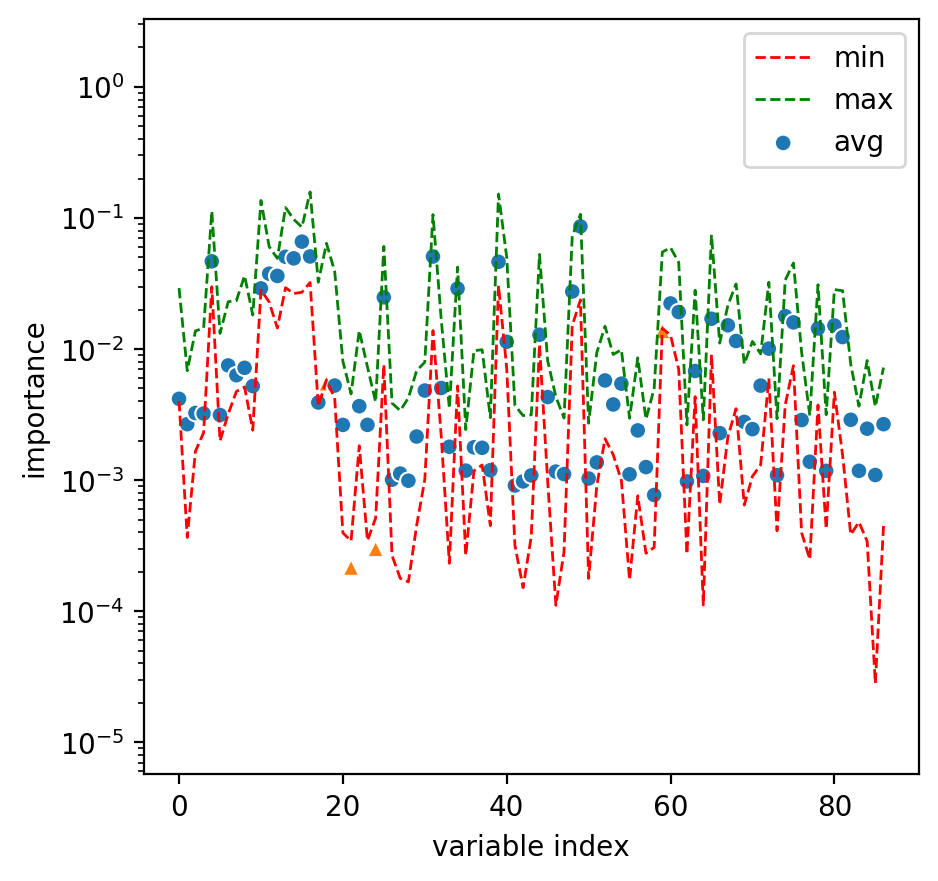

In [12]:
fig,ax = plt.subplots(figsize=([5,5]),dpi=200)
ax.set(yscale='log')
sns.scatterplot(x='x',y='avg',data=yerr_plot,markers=['o','^'],hue='sig',style='sig')
sns.lineplot(x='x',y='min_perm',data=yerr_plot,color='red')
sns.lineplot(x='x',y='max_perm',data=yerr_plot,color='green')

ax.lines[0].set_linestyle('--')
ax.lines[0].set_linewidth(1)

ax.lines[1].set_linestyle('--')
ax.lines[1].set_linewidth(1)

plt.legend(['min','max','avg'])

plt.xlabel('variable index')
plt.ylabel('importance');


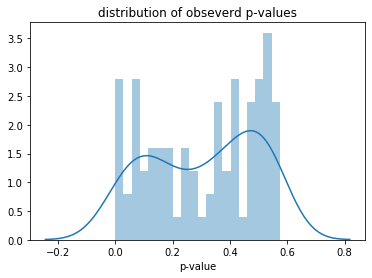

In [13]:
mi = mean_varimportance
pvalues = iperc(mi,feature_importance_perm)
sns.distplot(pvalues.iloc[:,0].astype('float'),20)
plt.title('distribution of obseverd p-values');

In [14]:
pvalues.loc[pvalues['p-value']<0.05,:]

,p-value
0,0.0114943
10,0.0114943
17,0.0344828
18,0
21,0
24,0
49,0.0229885
59,0
67,0.045977


In [15]:
# only select those variables that have p-value smaller than 0.05 (after bonferroni correction)
#mysel = pvalues.loc[pvalues.iloc[:,0]<(0.05/X.shape[0]),:].sort_values('p-value')
mysel = pvalues.loc[pvalues.iloc[:,0]<0.05,:].sort_values('p-value')

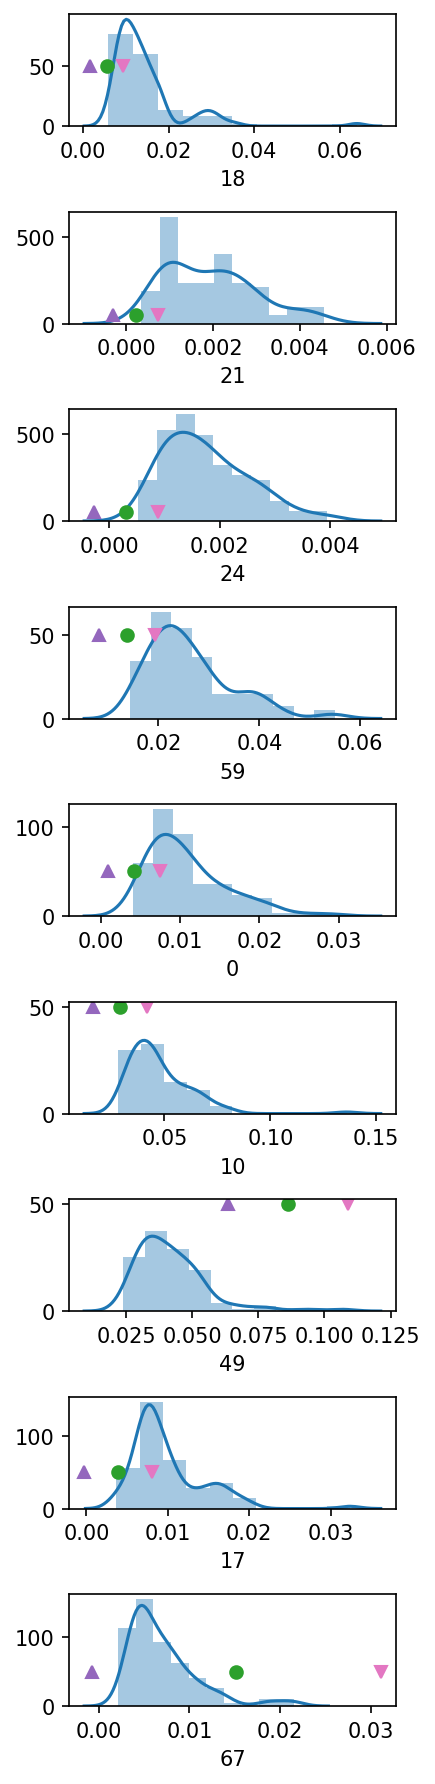

In [16]:
# plot those variables
nrplots = len(mysel.index.values)
fig = plt.figure(figsize=([3,12]),dpi=150)
ax = fig.subplots(nrows=nrplots,ncols=1)

yerr = pd.concat([mean_varimportance-2*pooled_std, mean_varimportance,mean_varimportance+2*pooled_std],axis=1)

for i in range(nrplots):                
    plt.subplot(ax[i])
    sns.distplot(feature_importance_perm.iloc[mysel.index.values[i],:],bins=10,ax=ax[i])
    plt.plot(mi[mysel.index.values[i]],0,mi[mysel.index.values[i]],50,'o')
    plt.plot(yerr.iloc[mysel.index.values[i],0],0,yerr.iloc[mysel.index.values[i],0],50,'^')
    plt.plot(yerr.iloc[mysel.index.values[i],2],0,yerr.iloc[mysel.index.values[i],2],50,'v')

    
plt.tight_layout()

# Write final results to file

In [17]:
df.head()

,wf,thrips,5.541_67.0557,7.060_95.0168,9.272_93.0728,9.472_91.0566,9.653_91.0565,10.148_93.0730,10.581_105.0363,10.873_119.0877,...,26.529_131.0872,26.595_91.0568,26.689_109.1032,26.803_111.0836,26.833_81.0727,27.083_97.0317,27.996_91.0565,28.382_97.0323,30.160_91.0569,32.503_159.8606
sample,,,,,,,,,,,,,,,,,,,,,
S lyc MM,non-toxic,non-toxic,0.00000,0.0,0.000,0.0000,88210.77165,0.00000,0.00000,32617.13711,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
S per LA1278,non-toxic,toxic,234383.78650,0.0,0.000,0.0000,131824.19000,0.00000,800290.02030,0.00000,...,0.0,0.0,0.0,9153.957334,0.0,0.0,0.0,0.0,0.0,0.0
S hua LA1364,non-toxic,non-toxic,0.00000,0.0,104528.752,45335.4665,27304.44693,90430.09761,0.00000,0.00000,...,0.0,0.0,0.0,5561.180230,0.0,0.0,0.0,0.0,0.0,0.0
S che LA1401,non-toxic,toxic,0.00000,0.0,0.000,0.0000,457891.15640,0.00000,32459.72293,0.00000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
S pim LA1578,non-toxic,toxic,12809.66965,0.0,0.000,0.0000,221391.28520,0.00000,0.00000,24737.81096,...,0.0,0.0,0.0,9495.496480,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
#df_signif = df[]
signif = pvalues.loc[pvalues['p-value']<0.05,:]
signif.index.values

array([ 0, 10, 17, 18, 21, 24, 49, 59, 67])

In [19]:

X.iloc[:,signif.index.values]

,5.541_67.0557,11.844_91.0573,14.572_91.0565,14.537_91.0571,15.562_91.0570,20.136_79.0560,24.707_93.0725,25.356_105.0726,25.641_119.0875
sample,,,,,,,,,
S lyc MM,0.00000,1.904688e+05,0.000000,0.000000,0.00000,0.000000,75527.912740,0.000000e+00,0.000000e+00
S per LA1278,234383.78650,0.000000e+00,0.000000,0.000000,0.00000,0.000000,340948.901600,1.427795e+05,0.000000e+00
S hua LA1364,0.00000,7.764928e+04,28235.534220,82400.082750,0.00000,4238.271548,80871.240220,4.170737e+04,0.000000e+00
S che LA1401,0.00000,0.000000e+00,0.000000,0.000000,0.00000,0.000000,89948.670060,0.000000e+00,0.000000e+00
S pim LA1578,12809.66965,1.908459e+05,0.000000,0.000000,0.00000,0.000000,169286.503200,3.283908e+04,0.000000e+00
S hab LA1718,0.00000,2.365580e+06,34775.863880,14040.590340,0.00000,0.000000,63880.848730,7.343297e+04,1.065946e+04
S hab LA1777,0.00000,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,1.698677e+05,0.000000e+00
S chm LA1840,0.00000,2.606344e+04,4612.871657,9690.828363,0.00000,0.000000,3278.009080,0.000000e+00,0.000000e+00
S per LA1954,18698.82596,4.144142e+04,0.000000,8478.263931,0.00000,0.000000,52553.198930,1.437336e+04,0.000000e+00


## Sort dataframe by phenotypic class
To display a heatmap that shows the rows of the non-toxic genotypes followed by the rows of the toxic genotypes.

In [139]:
df_sorted = df.sort_values(by=["wf"])

# make a new column containing the accession and phenotypic class
df_sorted["genotypes and class"] = df_sorted.index.values + "_" + df_sorted["wf"]
df_sorted = df_sorted.set_index(df_sorted["genotypes and class"])

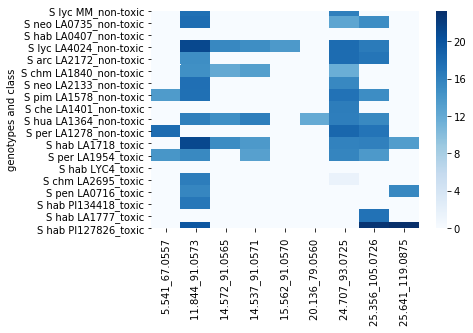

In [149]:
# X matrix similar to the one used for the Random Forest analysis (rows are reordered, not columns)
X = df_sorted.iloc[:,2:]

# add one for log offset
X_disp = X.replace(0,1) 

# display heatmap of log2(values)
log_function = lambda x: np.log2(x)
sns.heatmap(X_disp.iloc[:,signif.index.values].apply(log_function),cmap="Blues")

In [150]:
# filter to keep only significant metabolites
X_filt = X.iloc[:,signif.index.values]
X_filt.head()

,5.541_67.0557,11.844_91.0573,14.572_91.0565,14.537_91.0571,15.562_91.0570,20.136_79.0560,24.707_93.0725,25.356_105.0726,25.641_119.0875
genotypes and class,,,,,,,,,
S lyc MM_non-toxic,0.0,1.904688e+05,0.00000,0.00000,0.00000,0.0,75527.912740,0.00000,0.0
S neo LA0735_non-toxic,0.0,2.270831e+05,0.00000,0.00000,0.00000,0.0,6087.091886,31376.90480,0.0
S hab LA0407_non-toxic,0.0,0.000000e+00,0.00000,0.00000,0.00000,0.0,0.000000,0.00000,0.0
S lyc LA4024_non-toxic,0.0,2.366559e+06,42673.23629,30702.53575,14292.77153,0.0,243594.599800,97461.62512,0.0
S arc LA2172_non-toxic,0.0,2.966876e+04,0.00000,0.00000,0.00000,0.0,234855.748000,136468.20810,0.0


# Make plots for each candidate summing over the class

In [151]:
X_filt.insert(loc=0,column="id",value=X_filt.index.values)

In [152]:
X_filt.head()

,id,5.541_67.0557,11.844_91.0573,14.572_91.0565,14.537_91.0571,15.562_91.0570,20.136_79.0560,24.707_93.0725,25.356_105.0726,25.641_119.0875
genotypes and class,,,,,,,,,,
S lyc MM_non-toxic,S lyc MM_non-toxic,0.0,1.904688e+05,0.00000,0.00000,0.00000,0.0,75527.912740,0.00000,0.0
S neo LA0735_non-toxic,S neo LA0735_non-toxic,0.0,2.270831e+05,0.00000,0.00000,0.00000,0.0,6087.091886,31376.90480,0.0
S hab LA0407_non-toxic,S hab LA0407_non-toxic,0.0,0.000000e+00,0.00000,0.00000,0.00000,0.0,0.000000,0.00000,0.0
S lyc LA4024_non-toxic,S lyc LA4024_non-toxic,0.0,2.366559e+06,42673.23629,30702.53575,14292.77153,0.0,243594.599800,97461.62512,0.0
S arc LA2172_non-toxic,S arc LA2172_non-toxic,0.0,2.966876e+04,0.00000,0.00000,0.00000,0.0,234855.748000,136468.20810,0.0


In [153]:
cols = pd.DataFrame(X_filt["id"].str.split('_').tolist(),columns = ['genotype','class'])
cols


# new data frame with split value columns 
new = X_filt["id"].str.split("_", n = 1, expand = True) 
  
# making separate last name column from new data frame 
X_filt.loc[:,"wf"]= new[1]

# add index column
X_filt = X_filt.set_index("id")

/Users/mgalland/miniconda3/envs/rf/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


In [161]:
toxic = X_filt.iloc[:,0:-1][X_filt["wf"] == "toxic"].sum()
toxic

5.541_67.0557       1.869883e+04
11.844_91.0573      3.582277e+06
14.572_91.0565      3.477586e+04
14.537_91.0571      2.251885e+04
15.562_91.0570      0.000000e+00
20.136_79.0560      0.000000e+00
24.707_93.0725      1.164370e+05
25.356_105.0726     7.559031e+06
25.641_119.0875     1.034178e+07
dtype: float64

In [165]:
nontoxic = X_filt.iloc[:,0:-1][X_filt["wf"] == "non-toxic"].sum()
nontoxic

5.541_67.0557       2.471935e+05
11.844_91.0573      3.301865e+06
14.572_91.0565      7.552164e+04
14.537_91.0571      1.227934e+05
15.562_91.0570      1.429277e+04
20.136_79.0560      4.238272e+03
24.707_93.0725      1.287497e+06
25.356_105.0726     4.826327e+05
25.641_119.0875     0.000000e+00
dtype: float64

In [201]:
# prepare a dataframe for plotting
sumByClass = pd.DataFrame({'toxic':toxic, 'non-toxic':nontoxic})
sumByClass = sumByClass.reset_index()
sumByClass.columns.values[0]="candidate"
sumByClass = sumByClass.melt(id_vars="candidate",var_name="class",value_name="value")
sumByClass.head

<bound method NDFrame.head of            candidate      class         value
0     5.541_67.0557       toxic  1.869883e+04
1    11.844_91.0573       toxic  3.582277e+06
2    14.572_91.0565       toxic  3.477586e+04
3    14.537_91.0571       toxic  2.251885e+04
4    15.562_91.0570       toxic  0.000000e+00
5    20.136_79.0560       toxic  0.000000e+00
6    24.707_93.0725       toxic  1.164370e+05
7   25.356_105.0726       toxic  7.559031e+06
8   25.641_119.0875       toxic  1.034178e+07
9     5.541_67.0557   non-toxic  2.471935e+05
10   11.844_91.0573   non-toxic  3.301865e+06
11   14.572_91.0565   non-toxic  7.552164e+04
12   14.537_91.0571   non-toxic  1.227934e+05
13   15.562_91.0570   non-toxic  1.429277e+04
14   20.136_79.0560   non-toxic  4.238272e+03
15   24.707_93.0725   non-toxic  1.287497e+06
16  25.356_105.0726   non-toxic  4.826327e+05
17  25.641_119.0875   non-toxic  0.000000e+00>

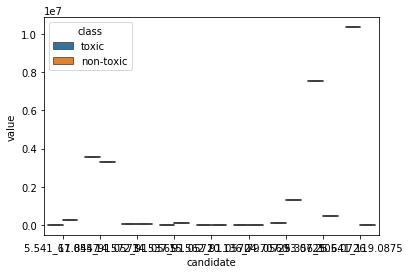

In [181]:
sns.boxplot(data=sumByClass,x="candidate",y="value",hue="class")

In [192]:
sumByClass.columns.values

array(['candidate', 'class', 'value'], dtype=object)

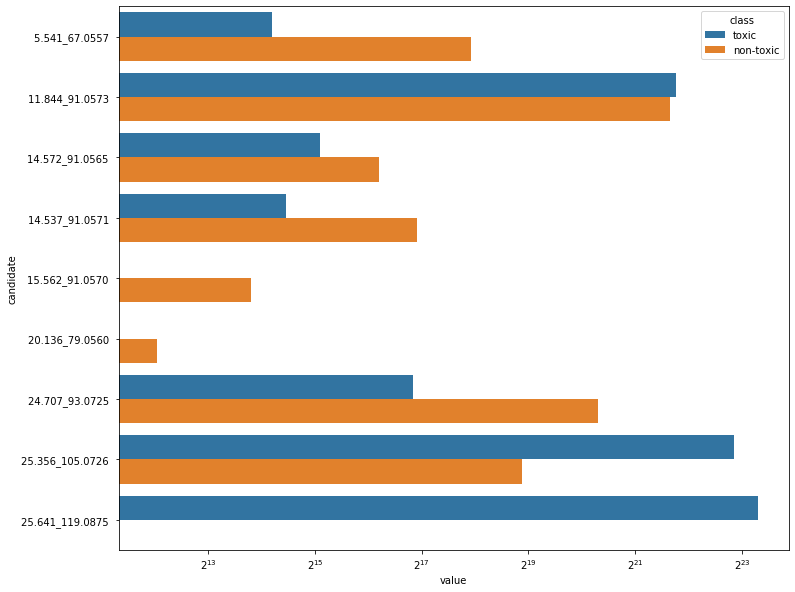

In [205]:
fig, ax = plt.subplots(figsize=(12,10))
ax.set_xscale("log",basex=2)
sns.barplot(x="value",y="candidate",hue="class",data=sumByClass,ax=ax)